# Aligning two coronal sections of adult mouse brain from MERFISH

In this notebook, we align two single cell resolution spatial transcriptomics datasets of coronal sections of the adult mouse brain from matched locations with respect to bregma assayed by MERFISH.

We will use `STalign` to achieve this alignment. We will first load the relevant code libraries.

In [1]:
## import dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import plotly
import requests

# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)

In [ ]:
# OPTION A: import STalign after pip or pipenv install
from STalign import STalign

In [2]:
## OPTION B: skip cell if installed STalign with pip or pipenv
import sys
sys.path.append("../../STalign") 

## import STalign from upper directory
import STalign

We have already downloaded single cell spatial transcriptomics datasets and placed the files in a folder called `merfish_data`.

We can read in the cell information for the first dataset using `pandas` as `pd`.

In [3]:
# Single cell data 1
# read in data
fname = '../merfish_data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv.gz'
df1 = pd.read_csv(fname)
print(df1.head())

                                Unnamed: 0  fov       volume    center_x  \
0  158338042824236264719696604356349910479   33   532.778772  617.916619   
1  260594727341160372355976405428092853003   33  1004.430016  596.808018   
2  307643940700812339199503248604719950662   33  1267.183208  578.880018   
3   30863303465976316429997331474071348973   33  1403.401822  572.616017   
4  313162718584097621688679244357302162401   33   507.949497  608.364018   

      center_y       min_x       max_x        min_y        max_y  
0  2666.520010  614.725219  621.108019  2657.545209  2675.494810  
1  2763.450012  589.669218  603.946818  2757.013212  2769.886812  
2  2748.978012  570.877217  586.882818  2740.489211  2757.466812  
3  2766.690012  564.937217  580.294818  2756.581212  2776.798812  
4  2687.418010  603.061218  613.666818  2682.493210  2692.342810  


For alignment with `STalign`, we only need the cell centroid information so we can pull out this information. We can further visualize the cell centroids to get a sense of the variation in cell density that we will be relying on for our alignment by plotting using `matplotlib.pyplot` as `plt`. 

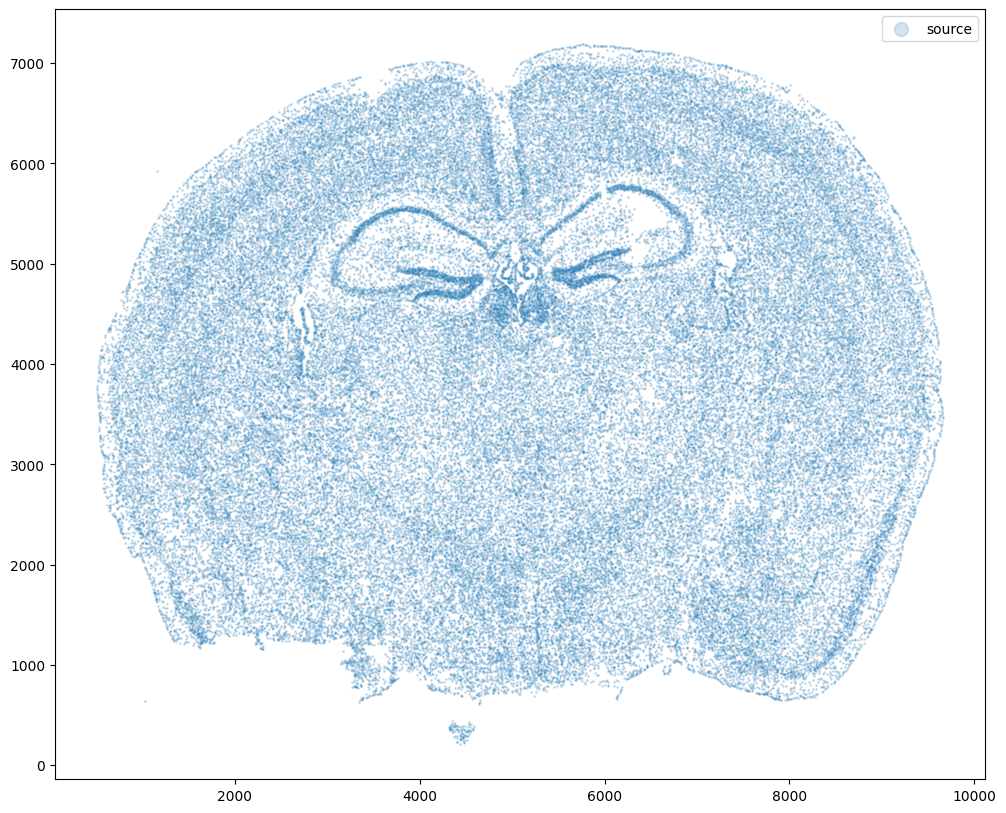

In [4]:
# get cell centroid coordinates
xI = np.array(df1['center_x'])
yI = np.array(df1['center_y'])

# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.2, label='source')
ax.legend(markerscale = 10)

Now, we can repeat this to get cell information from the second dataset.

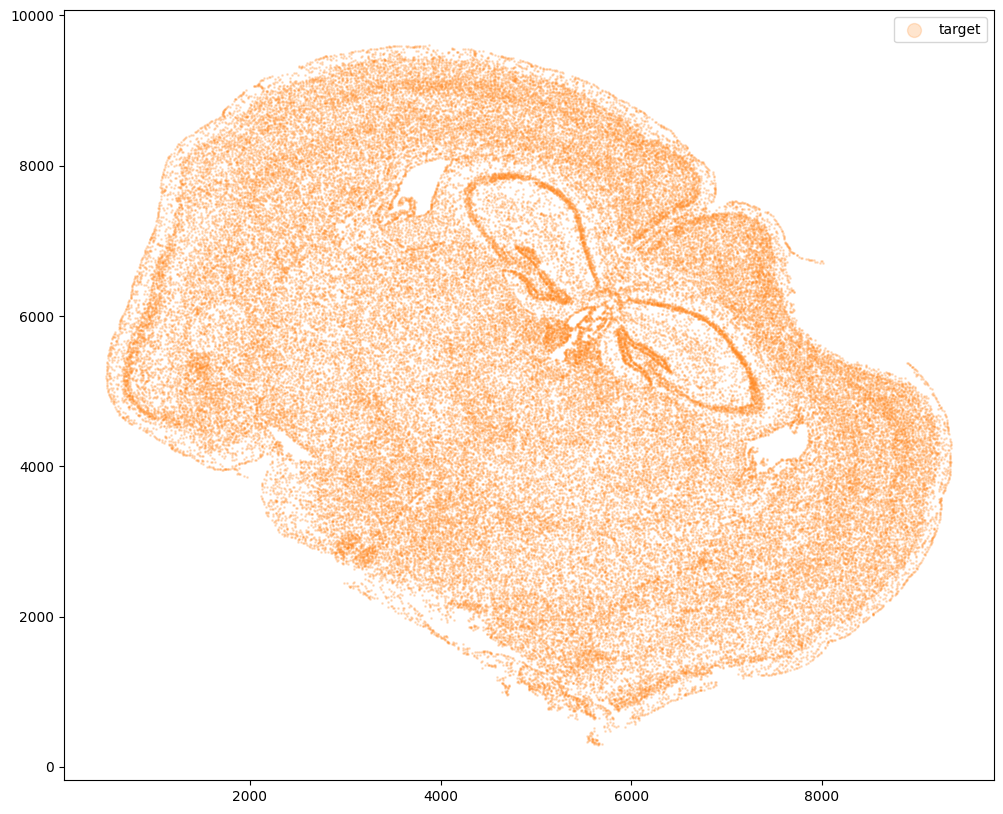

In [5]:
# Single cell data 2
# read in data
fname = '../merfish_data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_metadata_S2R2.csv.gz'

df2 = pd.read_csv(fname)

# get cell centroids
xJ = np.array(df2['center_x'])
yJ = np.array(df2['center_y'])

# plot
fig,ax = plt.subplots()
ax.scatter(xJ,yJ,s=1,alpha=0.2,c='#ff7f0e', label='target')
ax.legend(markerscale = 10)

Note that plotting the cell centroid positions from both datasets shows that non-linear local alignment is needed.

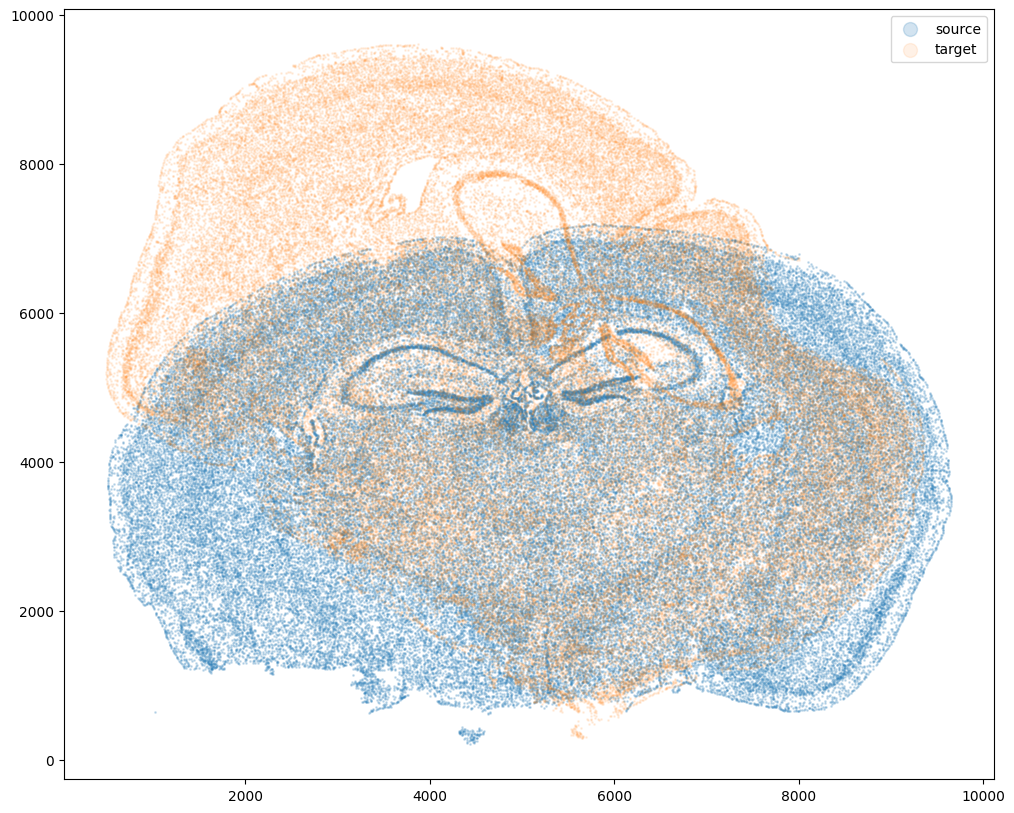

In [6]:
# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.2, label='source')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label= 'target')
ax.legend(markerscale = 10)

`STalign` relies on an interative gradient descent to align these two images. This performs quicker and better if the source and target are initially at a similar angle.

Evaluate the similarity of the rotation angle by viewing a side by side comparison. Change the value of `theta_deg`, until the rotation angle is similar. Note: the rotation here is defined in degrees and is in the clockwise direction.

The angle chosen will be used to construct a 2x2 rotation matrix `L` and a 2 element translation vector `T`.

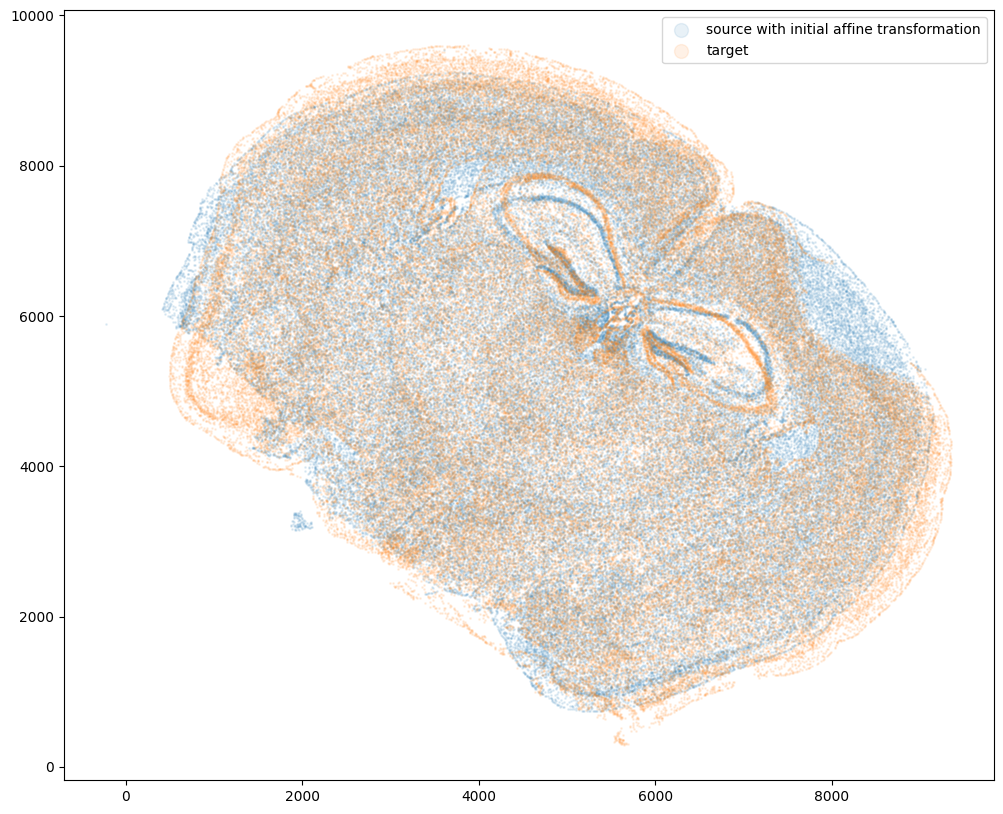

In [7]:
theta_deg = 45
theta0 = (np.pi/180)*-theta_deg

#rotation matrix 
#rotates about the origin
L = np.array([[np.cos(theta0),-np.sin(theta0)],
              [np.sin(theta0),np.cos(theta0)]])

source_L = np.matmul(L , np.array([xI, yI]))
xI_L = source_L[0]
yI_L = source_L[1]

#translation matrix
#effectively makes the rotation about the centroid of I (i.e the means of xI and yI]) 
#and also moves the centroid of I to the centroid of J
T = np.array([ np.mean(xI)- np.cos(theta0)*np.mean(xI) +np.sin(theta0)*np.mean(yI) - (np.mean(xI)-np.mean(xJ)),
              np.mean(yI)- np.sin(theta0)*np.mean(xI) -np.cos(theta0)*np.mean(yI) - (np.mean(yI)-np.mean(yJ))])

xI_L_T = xI_L + T[0]
yI_L_T = yI_L + T[1]


fig,ax = plt.subplots()
ax.scatter(xI_L_T,yI_L_T,s=1,alpha=0.1, label='source with initial affine transformation')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label = 'target')
ax.legend(markerscale = 10)

Now, we will first use `STalign` to rasterize the single cell centroid positions into an image. Assuming the single-cell centroid coordinates are in microns, we will perform this rasterization at a 30 micron resolution. We can visualize the resulting rasterized image.

Note that points are plotting with the origin at bottom left while images are typically plotted with origin at top left so we've used `invert_yaxis()` to invert the yaxis for visualization consistency. 

0 of 85958
10000 of 85958
20000 of 85958
30000 of 85958
40000 of 85958
50000 of 85958
60000 of 85958
70000 of 85958
80000 of 85958
85957 of 85958


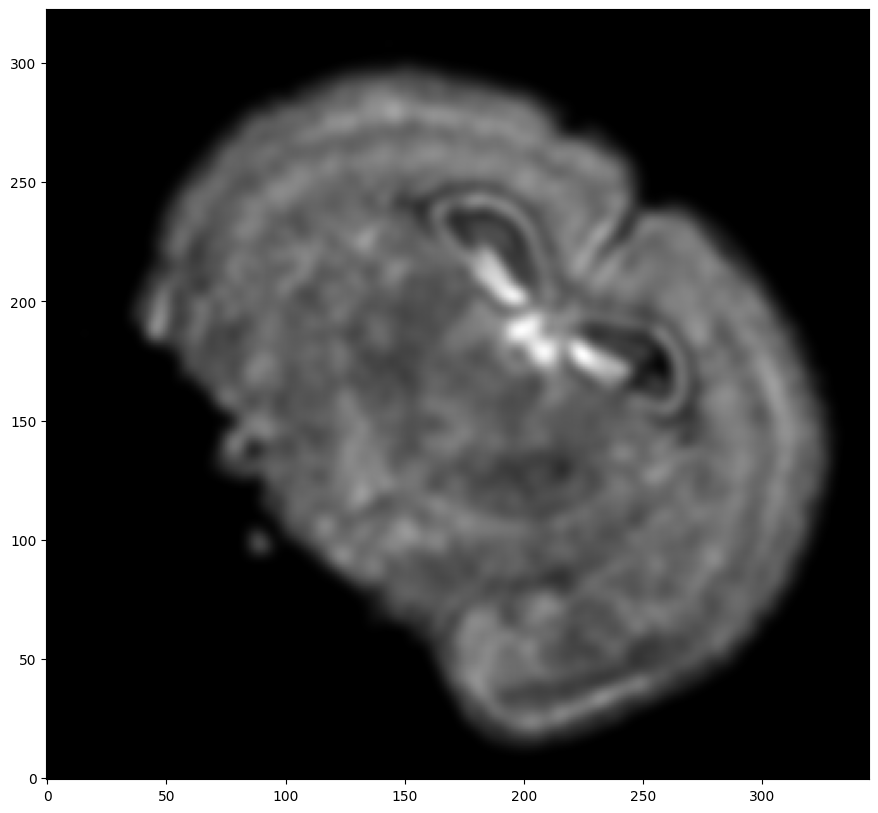

In [8]:
# rasterize at 30um resolution (assuming positions are in um units) and plot
XI,YI,I,fig = STalign.rasterize(xI_L_T,yI_L_T,dx=30,blur=1.5)

# plot
ax = fig.axes[0]
ax.invert_yaxis()

Repeat rasterization for target dataset.

0 of 84172
10000 of 84172
20000 of 84172
30000 of 84172
40000 of 84172
50000 of 84172
60000 of 84172
70000 of 84172
80000 of 84172
84171 of 84172


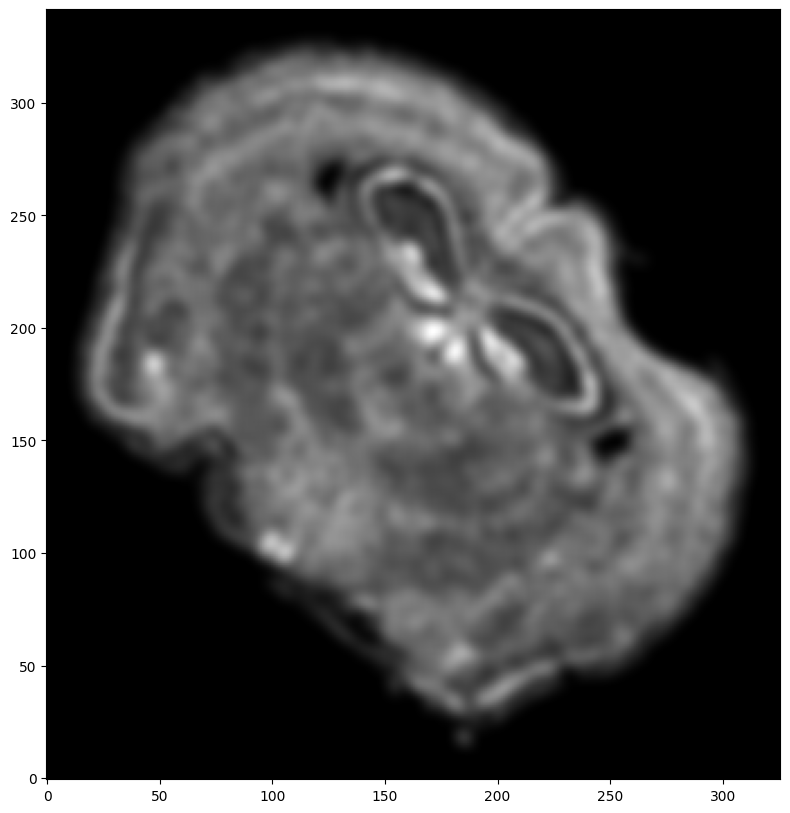

In [9]:
# rasterize and plot
XJ,YJ,J,fig = STalign.rasterize(xJ,yJ,dx=30, blur=1.5)
ax = fig.axes[0]
ax.invert_yaxis()

We can also plot the rasterized images next to each other.

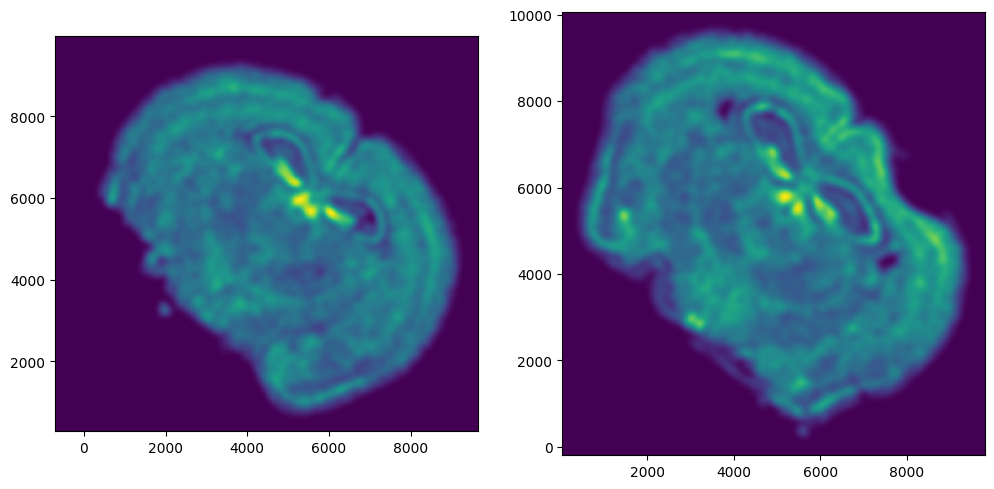

In [10]:
# get extent of images
extentI = STalign.extent_from_x((YI,XI))
extentJ = STalign.extent_from_x((YJ,XJ))

# plot rasterized images
fig,ax = plt.subplots(1,2)
ax[0].imshow(I[0], extent=extentI) 
ax[1].imshow(J[0], extent=extentJ)
ax[0].invert_yaxis()
ax[1].invert_yaxis()

Now we will perform our alignment. There are many parameters that can be tuned for performing this alignment. If we don't specify parameters, defaults will be used. 

/home/kalen/STalign/docs/notebooks/../../STalign/STalign.py:1043: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
/home/kalen/STalign/docs/notebooks/../../STalign/STalign.py:1044: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
/home/kalen/.local/share/virtualenvs/STalign-VWNsoi3D/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[at

CPU times: user 25min 25s, sys: 9.46 s, total: 25min 34s
Wall time: 14min 26s


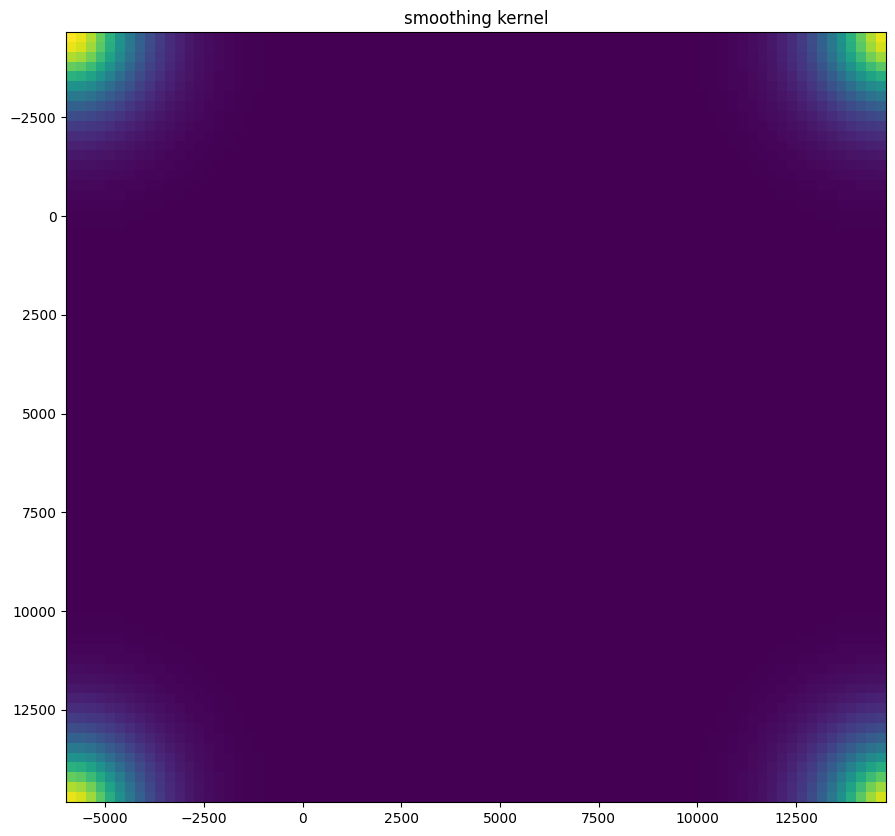

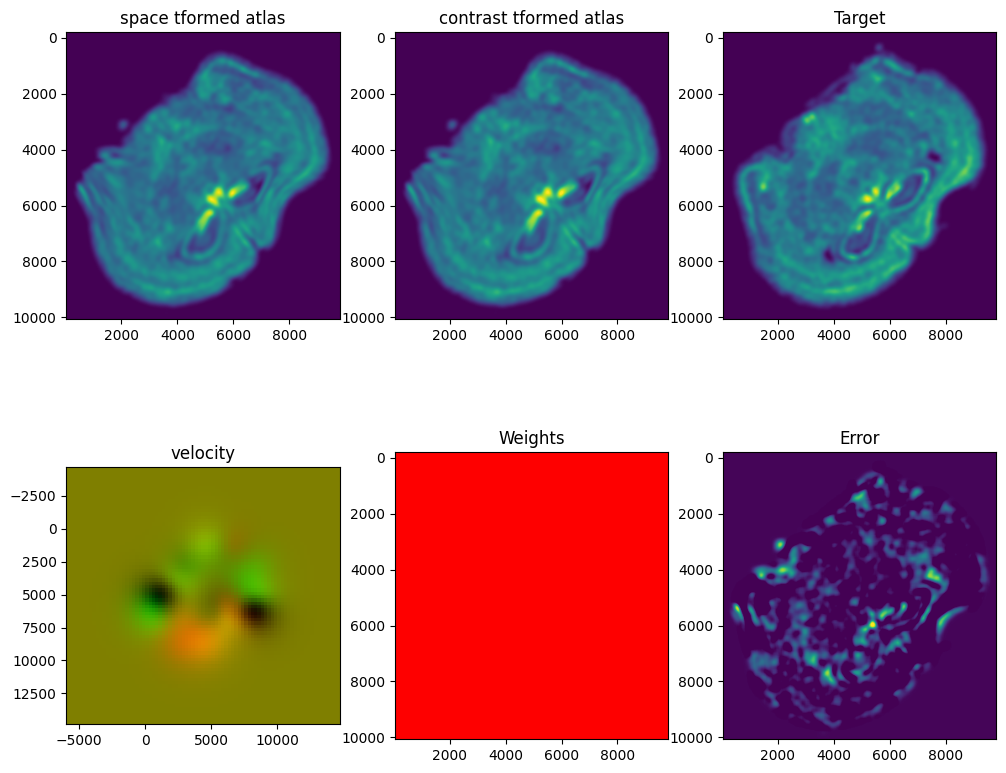

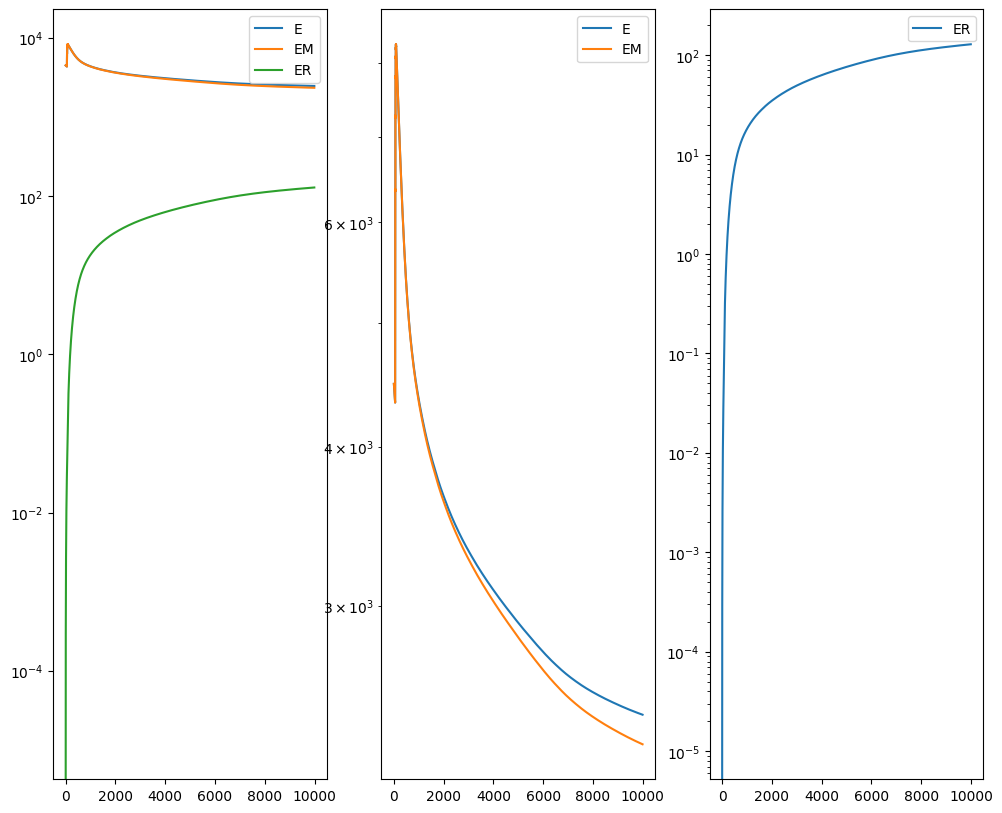

In [11]:
%%time
# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default
params = {
            'niter': 10000,
            'device':device,
            'epV': 50
          }

out = STalign.LDDMM([YI,XI],I,[YJ,XJ],J,**params)

In [29]:
# get necessary output variables
A = out['A']
v = out['v']
xv = out['xv']

Plots generated throughout the alignment can be used to give you a sense of whether the parameter choices are appropriate and whether your alignment is converging on a solution.

We can also evaluate the resulting alignment by applying the transformation to visualize how our source and target images were deformed to achieve the alignment. 

In [30]:
# set device for building tensors
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')

/home/kalen/.local/share/virtualenvs/STalign-VWNsoi3D/lib/python3.8/site-packages/torch/utils/_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


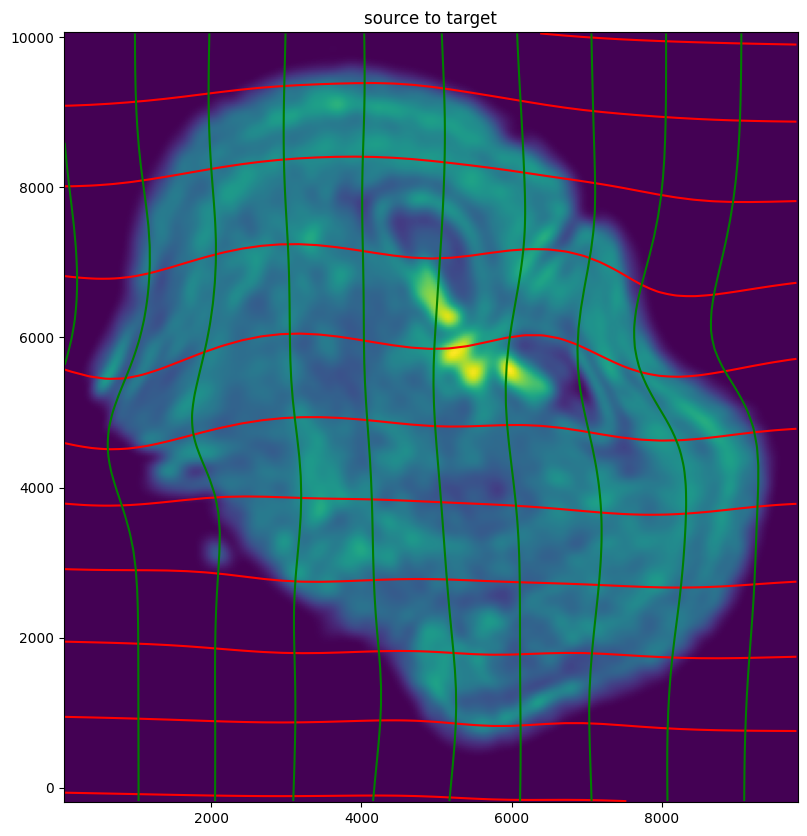

In [41]:
# apply transform
phii = STalign.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
phiI = STalign.transform_image_atlas_to_target(xv,v,A,[YI,XI],I,[YJ,XJ])

#switch tensor from cuda to cpu for plotting with numpy
if phii.is_cuda:
    phii = phii.cpu()
if phiI.is_cuda:
    phiI = phiI.cpu()

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('source to target')
ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)
ax.invert_yaxis()

Note that because of our use of LDDMM, the resulting transformation is invertible.

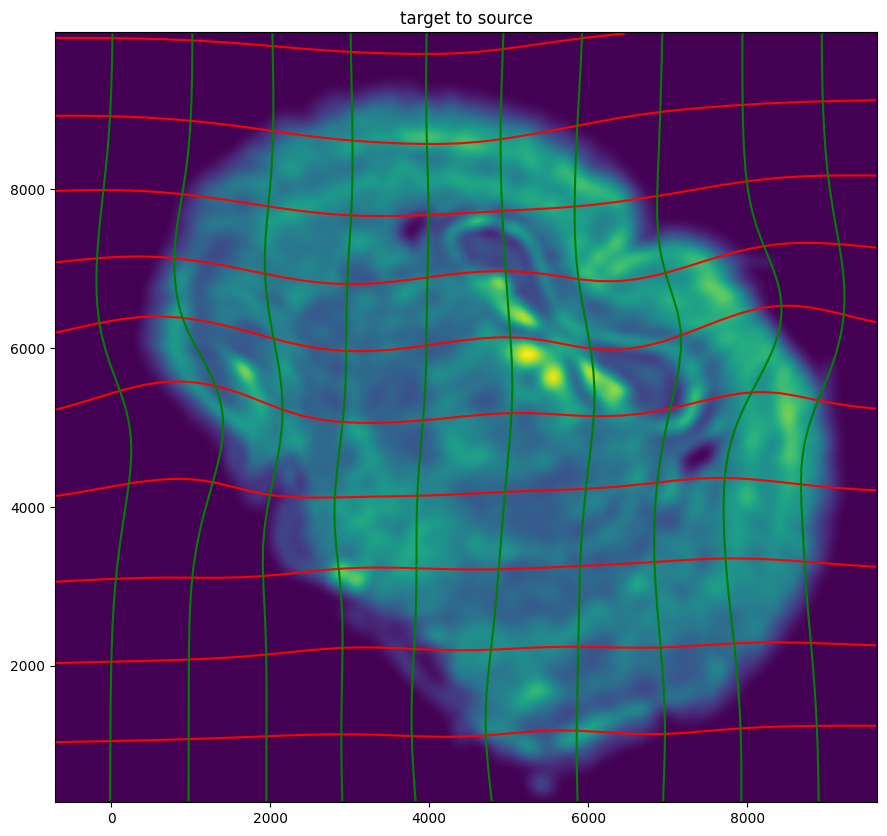

In [42]:
# transform is invertible
phi = STalign.build_transform(xv,v,A,XJ=[YI,XI],direction='f')
phiiJ = STalign.transform_image_target_to_atlas(xv,v,A,[YJ,XJ],J,[YI,XI])

#switch tensor from cuda to cpu for plotting with numpy
if phi.is_cuda:
    phi = phi.cpu()
if phiiJ.is_cuda:
    phiiJ = phiiJ.cpu()

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
ax.contour(XI,YI,phi[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XI,YI,phi[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('target to source')
ax.imshow(phiiJ.permute(1,2,0)/torch.max(phiiJ),extent=extentI)
ax.invert_yaxis()

Finally, we can apply our STalign transform to the original sets of single cell centroid positions (with initial affine transformation) to achieve their new aligned positions.

In [37]:
# apply transform to original points
tpointsI= STalign.transform_points_atlas_to_target(xv,v,A, np.stack([yI_L_T, xI_L_T], 1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsI.is_cuda:
    tpointsI = tpointsI.cpu()

#switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]

And we can visualize the results.

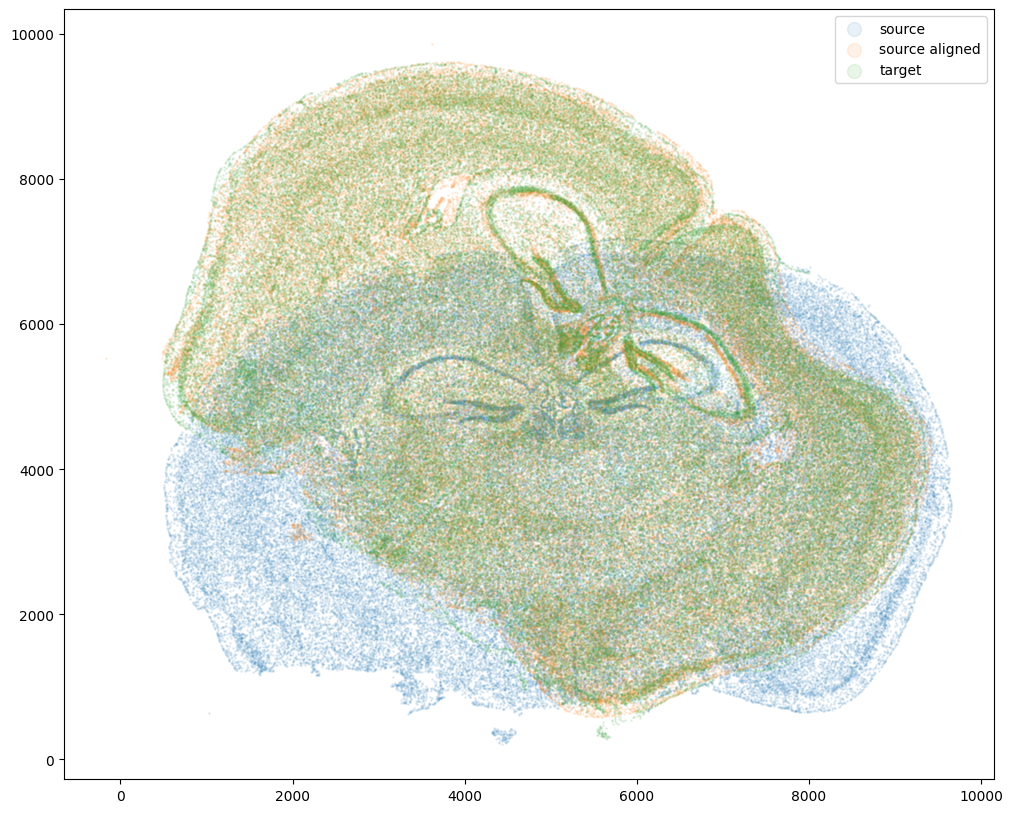

In [38]:
# plot results
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label='target')
ax.legend(markerscale = 10)

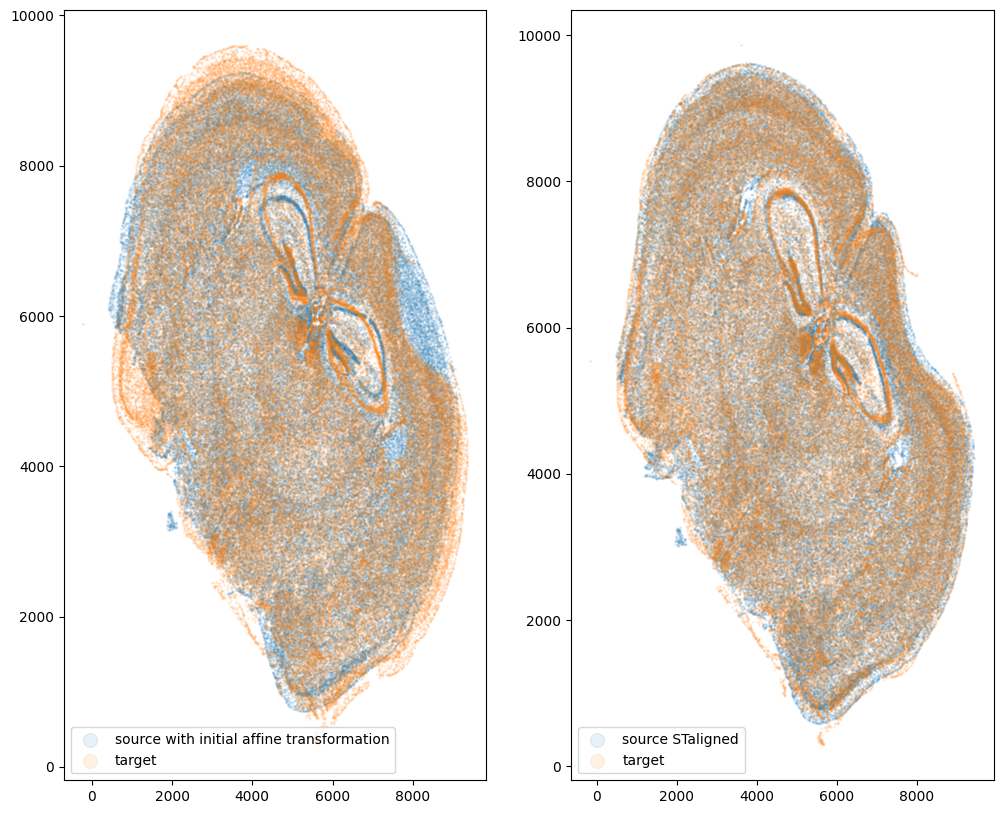

In [39]:
fig,ax = plt.subplots(1,2)
ax[0].scatter(xI_L_T,yI_L_T,s=1,alpha=0.1, label='source with initial affine transformation')
ax[0].scatter(xJ,yJ,s=1,alpha=0.1, label='target')
ax[1].scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source STaligned') 
ax[1].scatter(xJ,yJ,s=1,alpha=0.1, label='target')
ax[0].legend(markerscale = 10, loc = 'lower left')
ax[1].legend(markerscale = 10, loc = 'lower left')

And save the new aligned positions by appending to our original data

In [40]:
df3 = pd.DataFrame(

    {

        "aligned_x": xI_LDDMM,

        "aligned_y": yI_LDDMM,

    },


)

results = pd.concat([df1, df3], axis=1)
results.head()

Unnamed: 0  fov       volume    center_x  \
0  158338042824236264719696604356349910479   33   532.778772  617.916619   
1  260594727341160372355976405428092853003   33  1004.430016  596.808018   
2  307643940700812339199503248604719950662   33  1267.183208  578.880018   
3   30863303465976316429997331474071348973   33  1403.401822  572.616017   
4  313162718584097621688679244357302162401   33   507.949497  608.364018   

      center_y       min_x       max_x        min_y        max_y    aligned_x  \
0  2666.520010  614.725219  621.108019  2657.545209  2675.494810  1072.409961   
1  2763.450012  589.669218  603.946818  2757.013212  2769.886812  1109.912428   
2  2748.978012  570.877217  586.882818  2740.489211  2757.466812  1088.557174   
3  2766.690012  564.937217  580.294818  2756.581212  2776.798812  1093.635775   
4  2687.418010  603.061218  613.666818  2682.493210  2692.342810  1076.737927   

     aligned_y  
0  7618.526180  
1  7727.380716  
2  7727.036676  
3  7748.726637  
4  7645.783087

We will finally create a compressed `.csv.gz` file named `mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_STalign_to_Slice2_Replicate2.csv.gz`

In [18]:
results.to_csv('../merfish_data/mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_STalign_to_Slice2_Replicate2.csv.gz',
               compression='gzip')